# Start

In [ ]:
%pip install --upgrade gym==0.19.0
%pip install --upgrade gym[atari]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.3 MB/s 
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663116 sha256=c8e8ed81ce74fa9c54437a63b6f65d3311d05eb1e5fb914ea81f03204c67080c
  Stored in directory: /root/.cache/pip/wheels/ef/9d/70/8bea53f7edec2fdb4f98d9d64ac9f11aea95dfcb98099d7712
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 7.8 MB/s 
Reason for being yanked: re-release with new wheels
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


# Wrappers

In [ ]:
"""
Useful wrappers taken from OpenAI (https://github.com/openai/baselines)
"""

import numpy as np
from collections import deque
import gym
from gym import spaces
import cv2

import random

cv2.ocl.setUseOpenCL(False)


class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == "NOOP"

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = random.randint(
                1, self.noop_max + 1
            )  # pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == "FIRE"
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work.
        Expects inputs to be of shape height x width x num_channels
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(
            low=0, high=255, shape=(self.height, self.width, 1), dtype=np.uint8
        )

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self.width, self.height), interpolation=cv2.INTER_AREA
        )
        return frame[:, :, None]


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        Expects inputs to be of shape num_channels x height x width.
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(
            low=0, high=255, shape=(shp[0] * k, shp[1], shp[2]), dtype=np.uint8
        )

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0


class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers."""
        self._frames = frames

    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=0)
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._frames)

    def __getitem__(self, i):
        return self._frames[i]


class PyTorchFrame(gym.ObservationWrapper):
    """Image shape to num_channels x height x width"""

    def __init__(self, env):
        super(PyTorchFrame, self).__init__(env)
        shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(shape[-1], shape[0], shape[1]), dtype=np.uint8
        )

    def observation(self, observation):
        return np.rollaxis(observation, 2)


# Reply Buffer

In [ ]:
import numpy as np


class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices)

# Model

In [ ]:
from gym import spaces
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    """
    A basic implementation of a Deep Q-Network. The architecture is the same as that described in the
    Nature DQN paper.
    """

    def __init__(self, observation_space: spaces.Box, action_space: spaces.Discrete):
        """
        Initialise the DQN
        :param observation_space: the state space of the environment
        :param action_space: the action space of the environment
        """
        super().__init__()
        assert (
            type(observation_space) == spaces.Box
        ), "observation_space must be of type Box"
        assert (
            len(observation_space.shape) == 3
        ), "observation space must have the form channels x width x height"
        assert (
            type(action_space) == spaces.Discrete
        ), "action_space must be of type Discrete"
        
        
        #  input image is 84 x 84 X 4 
        #  first hidden layer convolves 16 8 x 8 filters with stride 4
        #  it means we do a 8 x 8 convolution without padding and stride=4
        #  stride shrinks the size to ceil((n+f-1)/s) where ’n’ is input dimensions ‘f’ is filter size and ‘s’ is stride length
        #  the input image will be strinked to ((84+8-1)/4)
        #  output layer is fully connected with single output for each valid action
        
        # num out features in current layer is equal to num in features in lext layer
  
        # self.convolutions = nn.Sequential(
            
        #     #  first hidden layer convolves 16 8 x 8 filters with stride 4
        #     nn.Conv2d(observation_space.shape[0], 32, 8, stride=4),
        #     nn.ReLU(),
        #     #  second layer convolves 32 4x4 filters with stride 2 -> num in_features is 32
        #     #  because num out_features in current layer has to be equal to num in_features in lext layer
        #     #  i then said num out_fearures for the first layer is 32, idk
        #     #  So for the num out_features i said because Deep Q-Learning uses 2 neural networks 
        #     #  so at every step weights from the main network are copied to the target network
        #     #  so at each step 2 copies of the input are produced 
        #     #  so the output will be twice the input
        #     #  idk if this understanding is correct
        #     nn.Conv2d(32, 64, 4, stride=2),
        #     nn.ReLU(),
        #     #  final hidden layer is fully connected with 256 rectifier units -> mnih paper has 512 
        #     nn.Conv2d(64, 64, 3, stride=1),
        #     nn.ReLU(),
        # )

        # self.fully_connected_layer = nn.Sequential(
        #     nn.Linear(in_features=64*7*7 , out_features=512), #512 not 256 
        #     nn.ReLU(),
        #     nn.Linear(in_features=512, out_features=action_space.n)
        # )
        self.conv1 = nn.Conv2d(observation_space.shape[0],32, 8,stride=4)
        #self.maxpool1 = MaxPool2d(kernel_size=(1, 1), stride=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4,stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3,stride=1)
        #self.maxpool2 = MaxPool2d(kernel_size=1, stride=(2, 2))
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=action_space.n)

    def forward(self, x):
        # output = self.convolutions(x)
        # output = self.fully_connected_layer(output.view(x.size()[0],-1))
        # return output
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Agent

In [ ]:
from torch.optim import Adam
from torch import nn
import torch

import torch.nn.functional as F

device = "cuda"


class DQNAgent:
    def __init__(
        self,
        observation_space: spaces.Box,
        action_space: spaces.Discrete,
        replay_buffer: ReplayBuffer,
        use_double_dqn,
        lr,
        batch_size,
        gamma,
    ):
        """
        Initialise the DQN algorithm using the Adam optimiser
        :param action_space: the action space of the environment
        :param observation_space: the state space of the environment
        :param replay_buffer: storage for experience replay
        :param lr: the learning rate for Adam
        :param batch_size: the batch size
        :param gamma: the discount factor
        """

        # TODO: Initialise agent's networks, optimiser and replay buffer -> Done 
        self.lr = lr
        self.replay_buffer = replay_buffer
        self.gamma = gamma
        self.batch_size = batch_size
        self.use_double_dqn = use_double_dqn
        #agents networks
        self.target_network = DQN(observation_space,action_space).to(device)
        self.policy_network = DQN(observation_space,action_space).to(device)
        #agents optimiser 
        self.optimiser = Adam(self.policy_network.parameters(),lr=self.lr)
        
        # raise NotImplementedError

    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """
        # TODO -> done
        #   Optimise the TD-error over a single minibatch of transitions
        #   Sample the minibatch from the replay-memory
        #   using done (as a float) instead of if statement
        #   return loss

        # get batch from replay buffer and convert info into tensors
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        tensor_states = torch.from_numpy(states/255.0).float().to(device)
        tensor_next_states = torch.from_numpy(next_states/255.0).float().to(device)
        tensor_actions = torch.from_numpy(actions).long().to(device)
        tensor_rewards = torch.from_numpy(rewards).float().to(device)
        tensor_dones = torch.from_numpy(dones).float().to(device)

        # don't track gradients
        with torch.no_grad():
            # calculate target
            estimate = None
            if self.use_double_dqn:
                # get next action from the other network
                _, next_action = self.policy_network(tensor_states).max(1)
                # get next q from target network
                estimate = self.target_network(tensor_next_states).gather(1, next_action.unsqueeze(1)).squeeze()
            else:
                estimate = None
              
                # get next q from target network
                

        estimate = self.target_network(tensor_next_states).max(1)

        c = self.gamma * estimate[0]
        target = tensor_rewards + (1 - tensor_dones) * c

        # backpropagation
        new_estimate = self.policy_network(tensor_states).gather(1, tensor_actions.unsqueeze(1)).squeeze()
        loss = nn.functional.l1_loss(new_estimate, target)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        # # remove from GPU
        # del tensor_states
        # del tensor_next_states

        return loss.item()

    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        # TODO update target_network parameters with policy_network parameters -> Done 
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def act(self, state: np.ndarray):
        """
        Select an action greedily from the Q-network given the state
        :param state: the current state
        :return: the action to take
        """
        # make rgb values have a range of [0,1]
        state = np.array(state)/255.0
        # convert state to tensor object and put on GPU
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # making sure gradients aren't saved for the following calculations
        with torch.no_grad():
            # get action-state values using the foward pass of the network
            qs = self.policy_network(state)
            # get max action
            _, action = qs.max(1)
            # return action from tensor object
            return action.item()

# Train

In [ ]:
if __name__ == "__main__":

    hyper_params = {
        "seed": 42,  # which seed to use
        "env": "PongNoFrameskip-v4",  # name of the game
        "replay-buffer-size": int(5e3),  # replay buffer size
        "learning-rate": 1e-4,  # learning rate for Adam optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(1e6),  # total number of steps to run the environment for
        "batch-size": 32,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # number of steps before learning starts
        "learning-freq": 1,  # number of iterations between every optimization step
        "use-double-dqn": False,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.01,  # e-greedy end threshold
        "eps-fraction": 0.1,  # fraction of num-steps
        "print-freq": 10,
    }

    np.random.seed(hyper_params["seed"])
    random.seed(hyper_params["seed"])

    assert "NoFrameskip" in hyper_params["env"], "Require environment with no frameskip"
    
    env = gym.make(hyper_params["env"])
    env.seed(hyper_params["seed"])

    # TODO Pick Gym wrappers to use
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    env = WarpFrame(env) #-> warp frame to 84x84
    env = PyTorchFrame(env) # turn to channel x height xwidth dimension for pytorch 
    env = FrameStack(env,4) #take the last 4 frames 
    # env = ClipRewardEnv(env)
    # record video every 50 episodes
    env = gym.wrappers.Monitor(env, '/content/drive/Shareddrives/Reinforcement_Learning/videos/', video_callable=lambda episode_id: episode_id % 50 == 0, force=True)
    
    replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])

    # TODO Create dqn agent
    agent = DQNAgent(env.observation_space,
        env.action_space,
        replay_buffer,
        use_double_dqn=hyper_params["use-double-dqn"],
        lr=hyper_params["learning-rate"],
        batch_size= hyper_params["batch-size"],
        gamma=hyper_params["discount-factor"])

    eps_timesteps = hyper_params["eps-fraction"] * float(hyper_params["num-steps"])
    episode_rewards = [0.0]

    state = env.reset()
    for t in range(hyper_params["num-steps"]):
        fraction = min(1.0, float(t) / eps_timesteps)
        eps_threshold = hyper_params["eps-start"] + fraction * (
            hyper_params["eps-end"] - hyper_params["eps-start"]
        )
        sample = random.random()
        # TODO done i think lol
        #  select random action if sample is less equal than eps_threshold
        # take step in env
        # add state, action, reward, next_state, float(done) to reply memory - cast done to float
        # add reward to episode_reward
        # action = None
        if sample < eps_threshold:
            action = random.randrange(env.action_space.n)
        else:
            action = agent.act(state)

        #take next step
        next_state, reward, done, _ = env.step(action) 
        agent.replay_buffer.add(state, action, reward, next_state, float(done))
        state = next_state

        episode_rewards[-1] += reward
        if done:
            state = env.reset()
            episode_rewards.append(0.0)

        if (
            t > hyper_params["learning-starts"]
            and t % hyper_params["learning-freq"] == 0
        ):
            agent.optimise_td_loss()

        if (
            t > hyper_params["learning-starts"]
            and t % hyper_params["target-update-freq"] == 0
        ):
            agent.update_target_network()

        num_episodes = len(episode_rewards)

        if (
            done
            and hyper_params["print-freq"] is not None
            and len(episode_rewards) % hyper_params["print-freq"] == 0
        ):
            mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
            print("********************************************************")
            print("steps: {}".format(t))
            print("episodes: {}".format(num_episodes))
            print("mean 100 episode reward: {}".format(mean_100ep_reward))
            print("% time spent exploring: {}".format(int(100 * eps_threshold)))
            print("********************************************************")
            np.savetxt('/content/drive/Shareddrives/Reinforcement_Learning/rewards.csv', episode_rewards)

********************************************************
steps: 8111
episodes: 10
mean 100 episode reward: -20.8
% time spent exploring: 91
********************************************************
********************************************************
steps: 17152
episodes: 20
mean 100 episode reward: -20.5
% time spent exploring: 83
********************************************************
********************************************************
steps: 26276
episodes: 30
mean 100 episode reward: -20.5
% time spent exploring: 73
********************************************************
********************************************************
steps: 35395
episodes: 40
mean 100 episode reward: -20.5
% time spent exploring: 64
********************************************************
********************************************************
steps: 44780
episodes: 50
mean 100 episode reward: -20.5
% time spent exploring: 55
********************************************************
***********

In [3]:
import pandas as pd
rewards = pd.read_csv("/content/drive/Shareddrives/Reinforcement_Learning/rewards.csv") 
rewards = rewards.to_numpy()

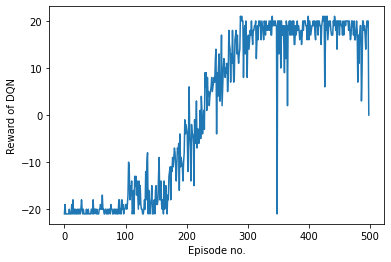

In [6]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(rewards))], rewards)
plt.xlabel('Episode no.')
plt.ylabel('Reward of DQN')
plt.show()
print()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# End